<a href="https://colab.research.google.com/github/RicardoMenna/MachineLearningTP4/blob/main/TPN%C2%B04_Covid_19_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo Práctico N°4**
**Ejercicio: Covid-19 Detection in Chest X-Ray Images**

In [11]:
"""Importaciones"""
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import cv2
from os import listdir
import pandas as pd
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage import exposure
from sklearn import svm
from sklearn import metrics

**En primer lugar se descarga y descomprimen las imágenes**

In [2]:
# Descarga y descomprimir
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip

--2021-11-03 23:43:44--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.121.250
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.121.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198985388 (190M) [application/octet-stream]
Saving to: ‘dataroot/fvk7h5dg2p-1.zip’

fvk7h5dg2p-1.zip    100%[===================>] 189.77M  29.7MB/s    in 7.1s    

2021-11-03 23:43:51 (26.6 MB/s) - ‘dataroot/fvk7h5dg2p-1.zip’ saved [198985388/198985388]



In [3]:
# Unzip
with zipfile.ZipFile(dataroot+"fvk7h5dg2p-1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

**Se realiza una visualización previa de las imágenes** 

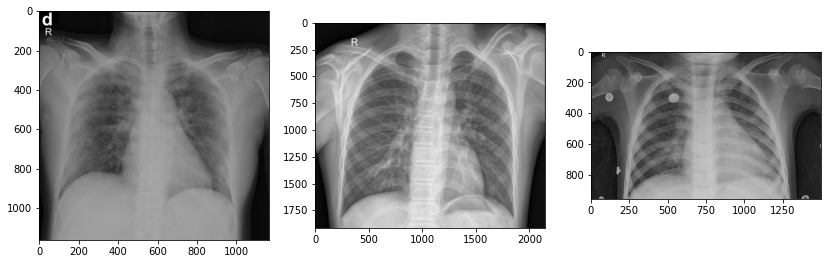

In [4]:
# Load and preview images
img_covid     = cv2.imread(dataroot+'COVID-19 cases/1-s2.0-S0929664620300449-gr2_lrg-d.jpg',0)
img_normal    = cv2.imread(dataroot+'Normal /IM-0011-0001-0001.jpeg',0)
img_pneumonia = cv2.imread(dataroot+'Pneumonia/person11_virus_38.jpeg',0)

plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(img_covid,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img_normal,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(img_pneumonia,cmap='gray')

**Listo todas las imágenes correspondientes a cada caso. Le cambio el tamaño interpolando para que todas queden iguales**

In [5]:
#Listo los archivos de cada carpeta
lis_covid=listdir(dataroot+"COVID-19 cases/")
lis_normal=listdir(dataroot+"Normal /")
lis_pneumonia=listdir(dataroot+"Pneumonia/")

#Creo listas de ceros con el tamaño de cada lista anterior 
#En estas listas estarán los imágenes redimensionadas
lis_covid_res=[0]* len(lis_covid)
lis_normal_res=[0]* len(lis_normal)
lis_pneumonia_res=[0]* len(lis_pneumonia)

#En estas listas estarán los nombres de las imágenes
lis_covid_name=[0]* len(lis_covid)
lis_normal_name=[0]* len(lis_normal)
lis_pneumonia_name=[0]* len(lis_pneumonia)

#Le cambio la dimensión a las imagenes de Covid y las guardo en la lista correspondiente
for i in range(len(lis_covid)):
  img=cv2.imread(dataroot+"COVID-19 cases/"+lis_covid[i],0)
  img_covid_res=cv2.resize(img, dsize=(256,512), interpolation=cv2.INTER_CUBIC)
  lis_covid_name[i]=lis_covid[i]
  lis_covid_res[i]=np.array(img_covid_res)

#Le cambio la dimensión a las imagenes Normal y las guardo en la lista correspondiente
for i in range(len(lis_normal)):
  img=cv2.imread(dataroot+"Normal /"+lis_normal[i],0)
  img_normal_res=cv2.resize(img, dsize=(256,512), interpolation=cv2.INTER_CUBIC)
  lis_normal_name[i]=lis_normal[i]
  lis_normal_res[i]=np.array(img_normal_res)

#Le cambio la dimensión a las imagenes de Pneumonia y las guardo en la lista correspondiente
for i in range(len(lis_pneumonia)):
  img=cv2.imread(dataroot+"Pneumonia/"+lis_pneumonia[i],0)
  img_pneumonia_res=cv2.resize(img, dsize=(256,512), interpolation=cv2.INTER_CUBIC)
  lis_pneumonia_name[i]=lis_pneumonia[i]
  lis_pneumonia_res[i]=np.array(img_pneumonia_res)

**Muestro las imágenes redimensionadas** 

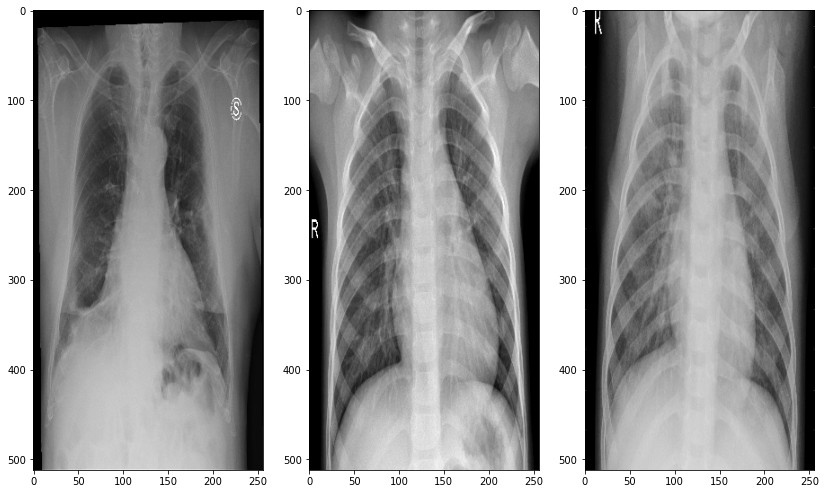

In [6]:
#Las imágenes mostradas no necesariamente coinciden con las anteriores mostradas
plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(lis_covid_res[10],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(lis_normal_res[10],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(lis_pneumonia_res[35],cmap='gray')

**Creo un histograma HOG de las imágenes redimensionadas**

In [9]:
#Creo los features HOG 
fd_covid= [0]* len(lis_covid)
images_covid= [0]* len(lis_covid)
fd_normal= [0]* len(lis_normal)
images_normal= [0]* len(lis_normal)
fd_pneumonia= [0]* len(lis_pneumonia)
images_pneumonia= [0]* len(lis_pneumonia)

for i in range(len(lis_covid)):
  fd, hog_covid = hog(lis_covid_res[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm="L2-Hys")
  fd_covid[i]= fd
  images_covid[i]= hog_covid

for i in range(len(lis_normal)):
  fd, hog_normal = hog(lis_normal_res[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm="L2-Hys")
  fd_normal[i]= fd
  images_normal[i]= hog_normal

for i in range(len(lis_pneumonia)):
  fd, hog_pneumonia = hog(lis_pneumonia_res[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm="L2-Hys")
  fd_pneumonia[i]= fd
  images_pneumonia[i]= hog_pneumonia



**Muestro algunas imagenes con su respectivo HOG**

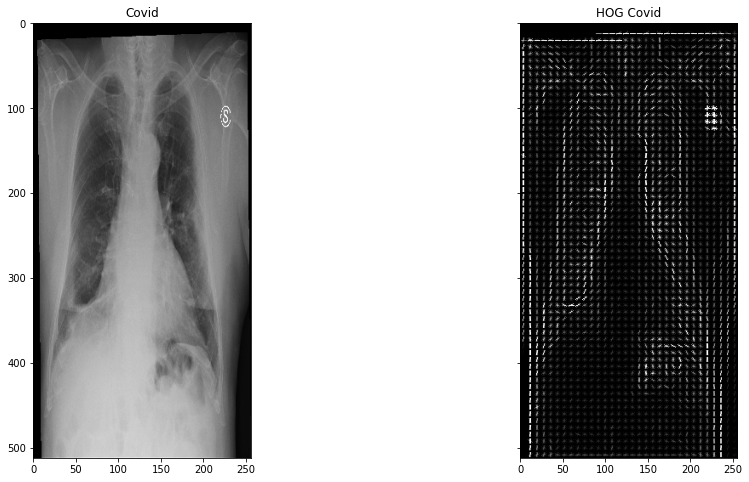

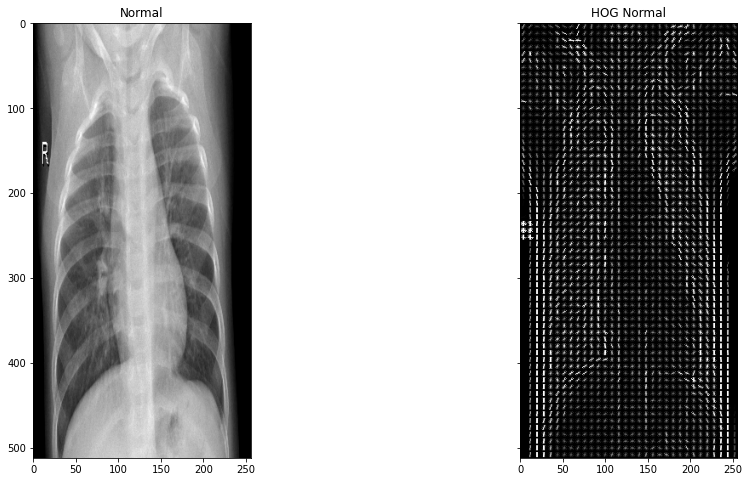

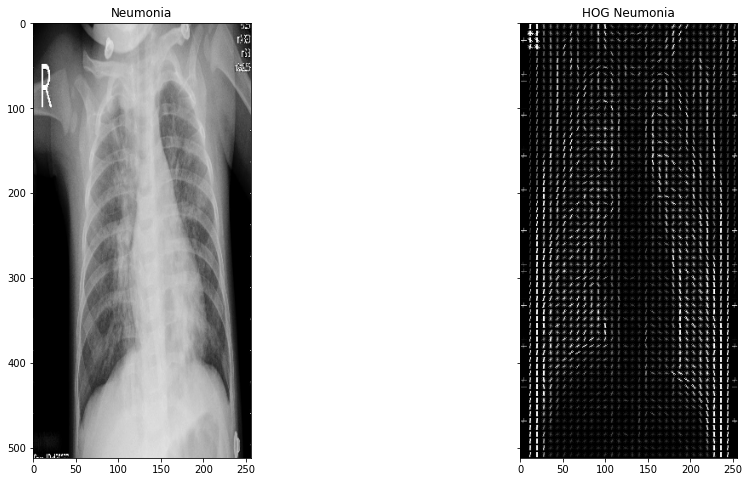

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(lis_covid_res[10], cmap=plt.cm.gray) 
ax1.set_title('Covid') 

# Cambiar la escala del histograma para una mejor visualización  
hog_image_rescaled = exposure.rescale_intensity(images_covid [10], in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('HOG Covid')

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 
ax3.imshow(lis_normal_res[120], cmap=plt.cm.gray) 
ax3.set_title('Normal') 

# Cambiar la escala del histograma para una mejor visualización  
hog_image_rescaled = exposure.rescale_intensity(images_normal[10], in_range=(0, 10)) 

ax4.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax4.set_title('HOG Normal')

fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 
ax5.imshow(lis_pneumonia_res[64], cmap=plt.cm.gray) 
ax5.set_title('Neumonia') 

# Cambiar la escala del histograma para una mejor visualización 
hog_image_rescaled = exposure.rescale_intensity(images_pneumonia[35], in_range=(0, 10)) 

ax6.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax6.set_title('HOG Neumonia')

plt.show()

In [13]:
#Creo una lista que contenga a las tres
fd_total= fd_covid + fd_normal + fd_pneumonia
fd_total=np.array(fd_total)
print(fd_total.shape)

(603, 70308)


**Teniendo todas las imagenes con su correspondiente HOG en diferentes listas, procedo a crear un dataframe con estos datos**

In [14]:
df_cov = pd.DataFrame({"Name": lis_covid_name, "Imagenes":lis_covid_res, "Histograma": images_covid, "Etiqueta": "Covid"})
df_nor = pd.DataFrame({"Name": lis_normal_name,"Imagenes": lis_normal_res, "Histograma": images_normal, "Etiqueta": "Normal"})
df_pne = pd.DataFrame({"Name": lis_pneumonia_name,"Imagenes": lis_pneumonia_res, "Histograma": images_pneumonia, "Etiqueta": "Pneumonia"})

#Creo un DataFrame con todos los datos
df_temp= df_cov.append(df_nor,ignore_index="true")
df = df_temp.append(df_pne, ignore_index="true")
df.head(10)

,Name,Imagenes,Histograma,Etiqueta
0,lancet-case2b.jpg,"[[74, 79, 92, 88, 95, 92, 100, 105, 107, 114, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Covid
1,covid-19-pneumonia-49-day8.jpg,"[[178, 220, 221, 222, 226, 222, 213, 218, 220,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Covid
2,covid-19-pneumonia-14-PA.png,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Covid
3,ryct.2020200034.fig5-day4.jpeg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Covid
4,all14238-fig-0002-m-f.jpg,"[[94, 84, 74, 77, 79, 84, 87, 92, 91, 95, 91, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Covid
5,lancet-case2a.jpg,"[[129, 129, 126, 124, 126, 120, 120, 95, 115, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Covid
6,E1724330-1866-4581-8CD8-CEC9B8AFEDDE.jpeg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Covid
7,nejmoa2001191_f4.jpeg,"[[53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Covid
8,35AF5C3B-D04D-4B4B-92B7-CB1F67D83085.jpeg,"[[114, 146, 185, 197, 205, 206, 203, 199, 202,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Covid
9,covid-19-pneumonia-22-day1-l.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Covid


**Ahora divido los datos para entrenamiento y testeo**

In [15]:
#Divido el conjunto de datos en subconjuntos de entrenar y probar:
X_train, X_test, y_train, y_test = train_test_split(fd_total, df.Etiqueta, train_size=0.8, random_state=1)
# Entrenar 80% y probar 20%
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(482, 70308)
(482,)
(121, 70308)
(121,)


**Al final entreno mi clasificador. Utilizo la Clasificación de vectores de soporte C implementado en Scikit-learn, que ofrece varios clasificadores implementados.**

In [16]:
# Clasificador de soportes vectoriales
clasificador = svm.SVC(gamma=0.001)
# Aprenda a clasificar el conjunto de entrenamiento
clasificador.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

**Realizo una predicción**

In [17]:
# Predecir usando X_test
y_predicted = clasificador.predict(X_test)

**Este método crea un informe de texto que muestra las principales métricas de clasificación. Cada fila indica la precisión, recuperación y puntuación f1 para cada categoría de clasificación.**

In [18]:
print("Clasificación reportada para clasificador {}\n{}\n".format(clasificador, metrics.classification_report(y_test, y_predicted)))

Clasificación reportada para clasificador SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
              precision    recall  f1-score   support

       Covid       0.98      0.98      0.98        46
      Normal       0.83      0.95      0.89        42
   Pneumonia       0.96      0.79      0.87        33

    accuracy                           0.92       121
   macro avg       0.92      0.91      0.91       121
weighted avg       0.92      0.92      0.92       121




**Se puede ampliar aún más estas métricas calculando la matriz de confusión:**

Confusion matrix:
[[45  1  0]
 [ 1 40  1]
 [ 0  7 26]]


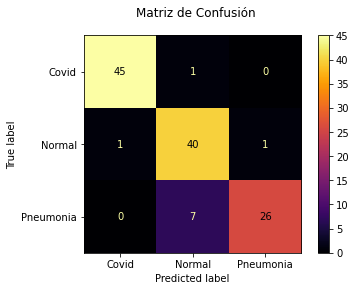

In [19]:
disp = metrics.plot_confusion_matrix(clasificador, X_test, y_test, cmap='inferno')
disp.figure_.suptitle("Matriz de Confusión")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

**Se puede observar que los resultados obtenidos son buenos, el clasificador funciona de manera óptima. La mayor falla la tiene prediciendo los pacientes con neumonía, incluso en esta circunstancia tiene un buen desempeño.**